In [1]:
# Import libaries
import numpy as np
import pandas as pd
import kagglehub
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import boxcox
import scipy.stats as stats
from statsmodels.graphics.regressionplots import abline_plot
import statsmodels.formula.api as smf
from sklearn.pipeline import make_pipeline
from scipy.stats import kendalltau
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from sklearn.preprocessing import StandardScaler
from scipy.stats import shapiro
from statsmodels.graphics.tsaplots import plot_acf

# Set pandas display options to show real numbers
pd.set_option('display.float_format', '{:.2f}'.format)

In [2]:
# Download latest version
path = kagglehub.dataset_download("yasserh/housing-prices-dataset")

print("Path to dataset files:", path)

# Upload the file to Google Colab
uploaded = files. upload()

100%|██████████| 4.63k/4.63k [00:00<00:00, 797kB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/yasserh/housing-prices-dataset/versions/1


Saving Housing.csv to Housing.csv


# **1. MULTIPLE LINEAR REGRESSION**




## A. Load the dataset

In [3]:
# Read the file
df = pd.read_csv('Housing.csv')
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


## B. Understand the dataset

In [4]:
# Check dataset info
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB
None


In [5]:
# Convert numerical columns (int64) to float
df[df.select_dtypes(include=['int64']).columns] = df.select_dtypes(include=['int64']).astype(float)

# Convert object columns to string
df[df.select_dtypes(include=['object']).columns] = df.select_dtypes(include=['object']).astype("str")

# Verify the changes
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   price             545 non-null    float64
 1   area              545 non-null    float64
 2   bedrooms          545 non-null    float64
 3   bathrooms         545 non-null    float64
 4   stories           545 non-null    float64
 5   mainroad          545 non-null    object 
 6   guestroom         545 non-null    object 
 7   basement          545 non-null    object 
 8   hotwaterheating   545 non-null    object 
 9   airconditioning   545 non-null    object 
 10  parking           545 non-null    float64
 11  prefarea          545 non-null    object 
 12  furnishingstatus  545 non-null    object 
dtypes: float64(6), object(7)
memory usage: 55.5+ KB
None


In [6]:
# Check for missing values
print(df.isnull().sum())

price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64


In [7]:
# Basic statistics
print(df.describe())

            price     area  bedrooms  bathrooms  stories  parking
count      545.00   545.00    545.00     545.00   545.00   545.00
mean   4766729.25  5150.54      2.97       1.29     1.81     0.69
std    1870439.62  2170.14      0.74       0.50     0.87     0.86
min    1750000.00  1650.00      1.00       1.00     1.00     0.00
25%    3430000.00  3600.00      2.00       1.00     1.00     0.00
50%    4340000.00  4600.00      3.00       1.00     2.00     0.00
75%    5740000.00  6360.00      3.00       2.00     2.00     1.00
max   13300000.00 16200.00      6.00       4.00     4.00     3.00


In [8]:
# Check uniqueness in categorical columns
categorical_columns = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus']
for col in categorical_columns:
    unique_values = df[col].unique()
    print(f"Unique values in {col}: {unique_values}")

Unique values in mainroad: ['yes' 'no']
Unique values in guestroom: ['no' 'yes']
Unique values in basement: ['no' 'yes']
Unique values in hotwaterheating: ['no' 'yes']
Unique values in airconditioning: ['yes' 'no']
Unique values in prefarea: ['yes' 'no']
Unique values in furnishingstatus: ['furnished' 'semi-furnished' 'unfurnished']


## C. Exploratory Data Analysis




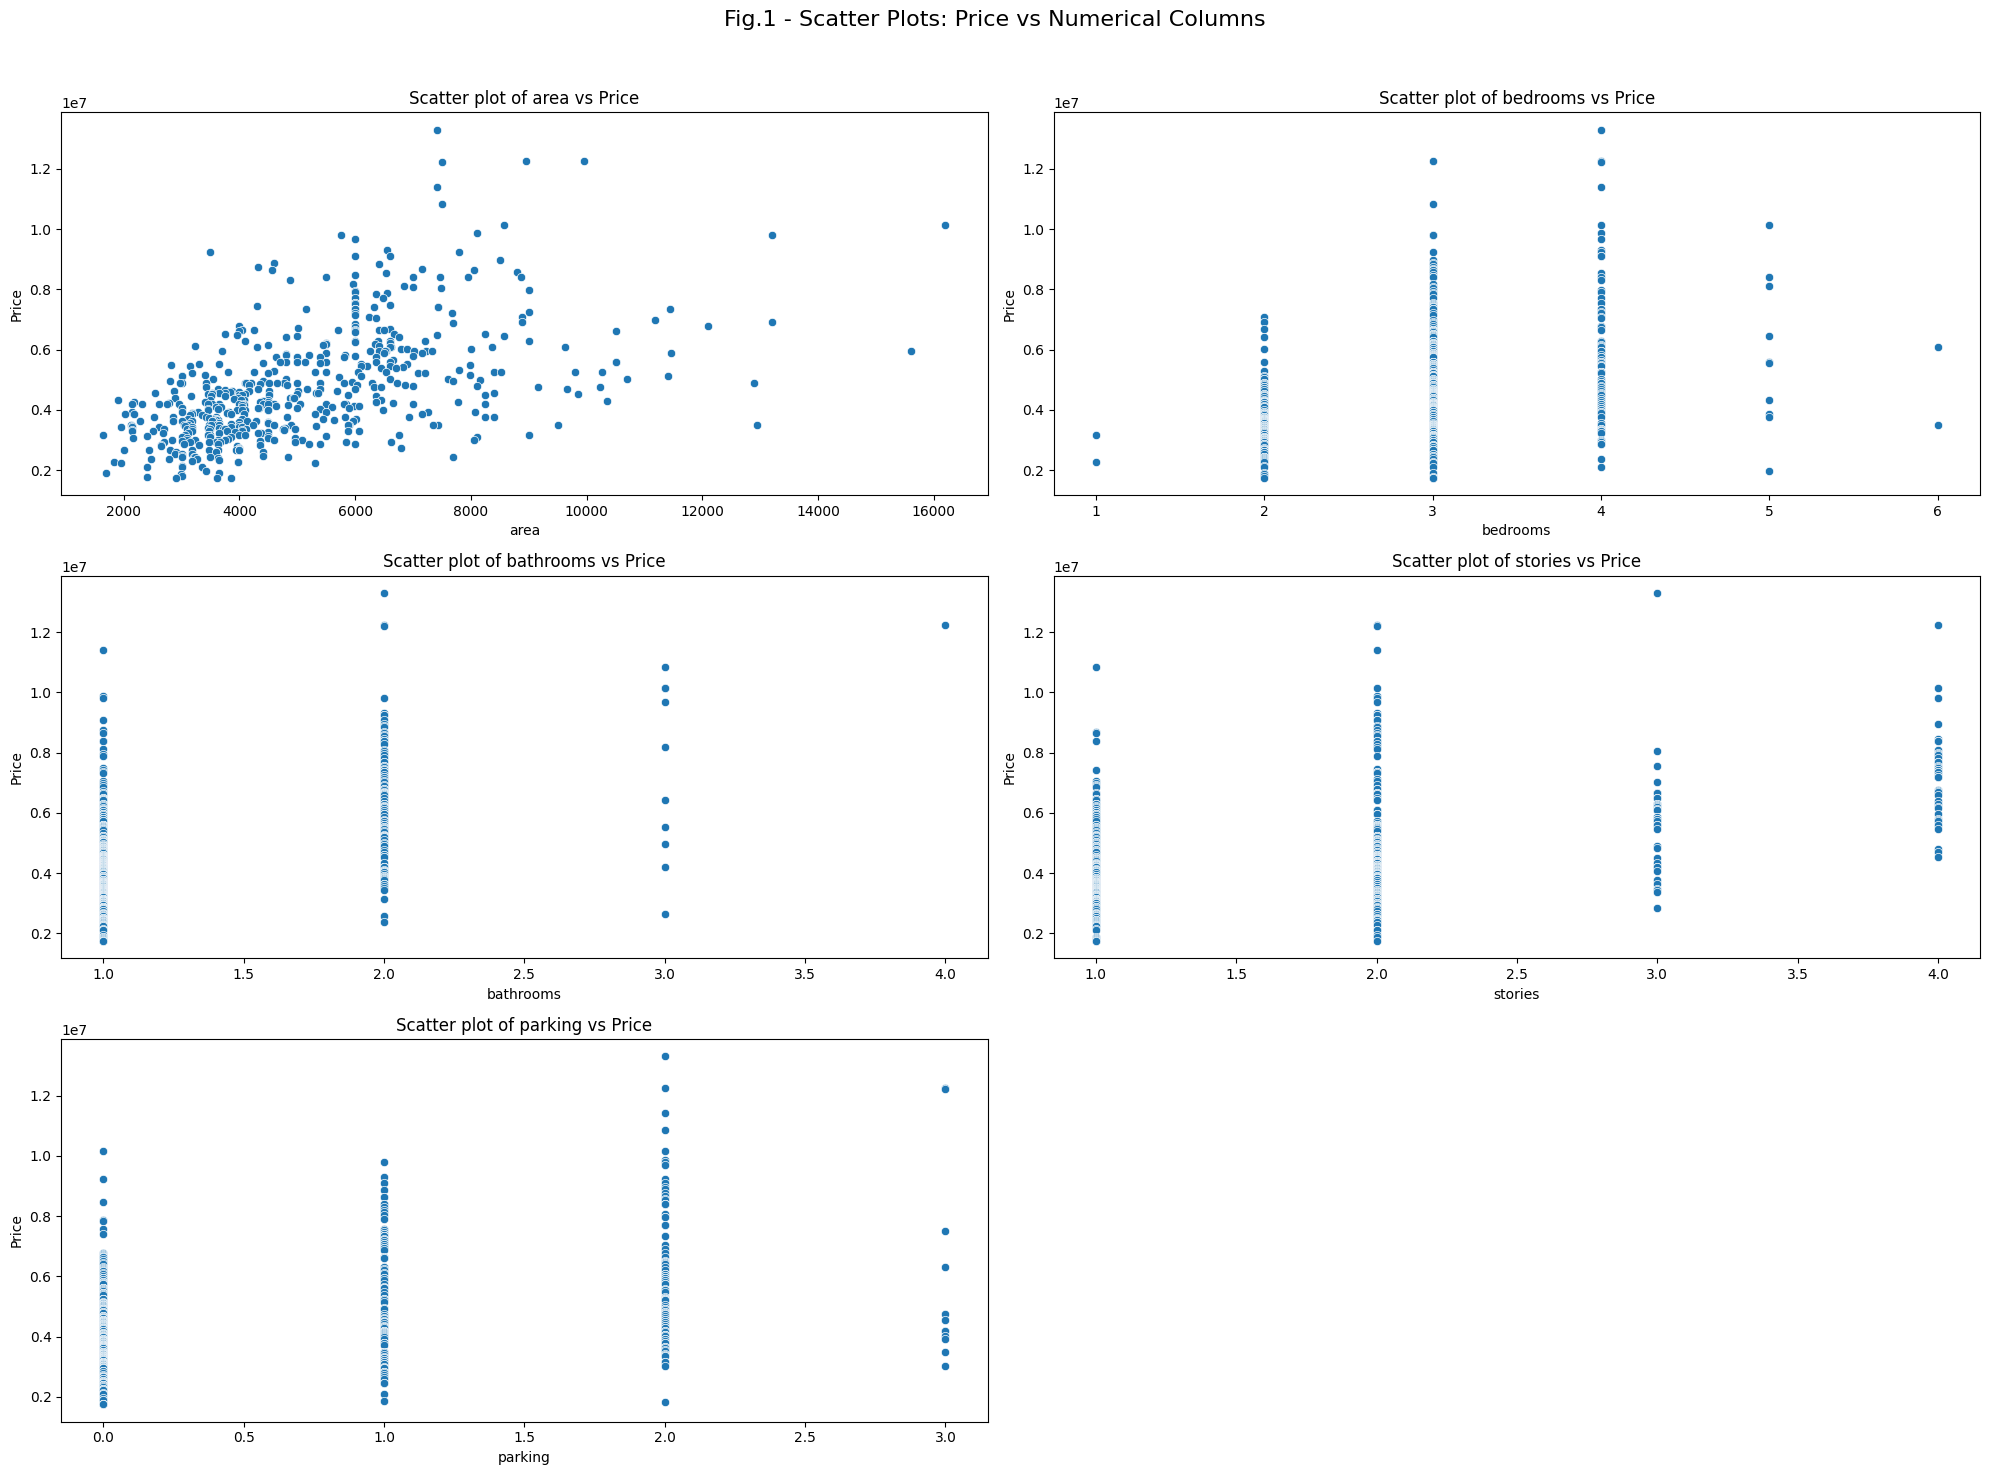

In [9]:
# Drop categorical columns to get numerical variables
numerical_val = df.drop(columns=categorical_columns)

# Remove 'price' from the independent numerical variables
num_vars = [var for var in numerical_val.columns if var != 'price']

# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 15))
fig.suptitle('Fig.1 - Scatter Plots: Price vs Numerical Columns', fontsize=16)
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

# Plot each numerical variable against 'price'
for plot_idx, var in enumerate(num_vars):  # Use a separate index for subplots
    sns.scatterplot(x=df[var], y=df['price'], ax=axes[plot_idx])
    axes[plot_idx].set_title(f'Scatter plot of {var} vs Price')
    axes[plot_idx].set_xlabel(var)
    axes[plot_idx].set_ylabel('Price')

# Hide any unused subplots
for j in range(plot_idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
plt.show()

- As we can see in **Figure 1**, the majority of the scatter plots, **except for area vs. price**, show a **vertical straight line**. This indicates that the independent variables \(X\) are constant and **do not provide any useful information** for predicting the dependent variable \(Y\). Even in the first plot, we can see that at around **6000 m²**, there are multiple price options.  

- In this case, we **cannot use regression models** that rely on those features to predict `price`.  



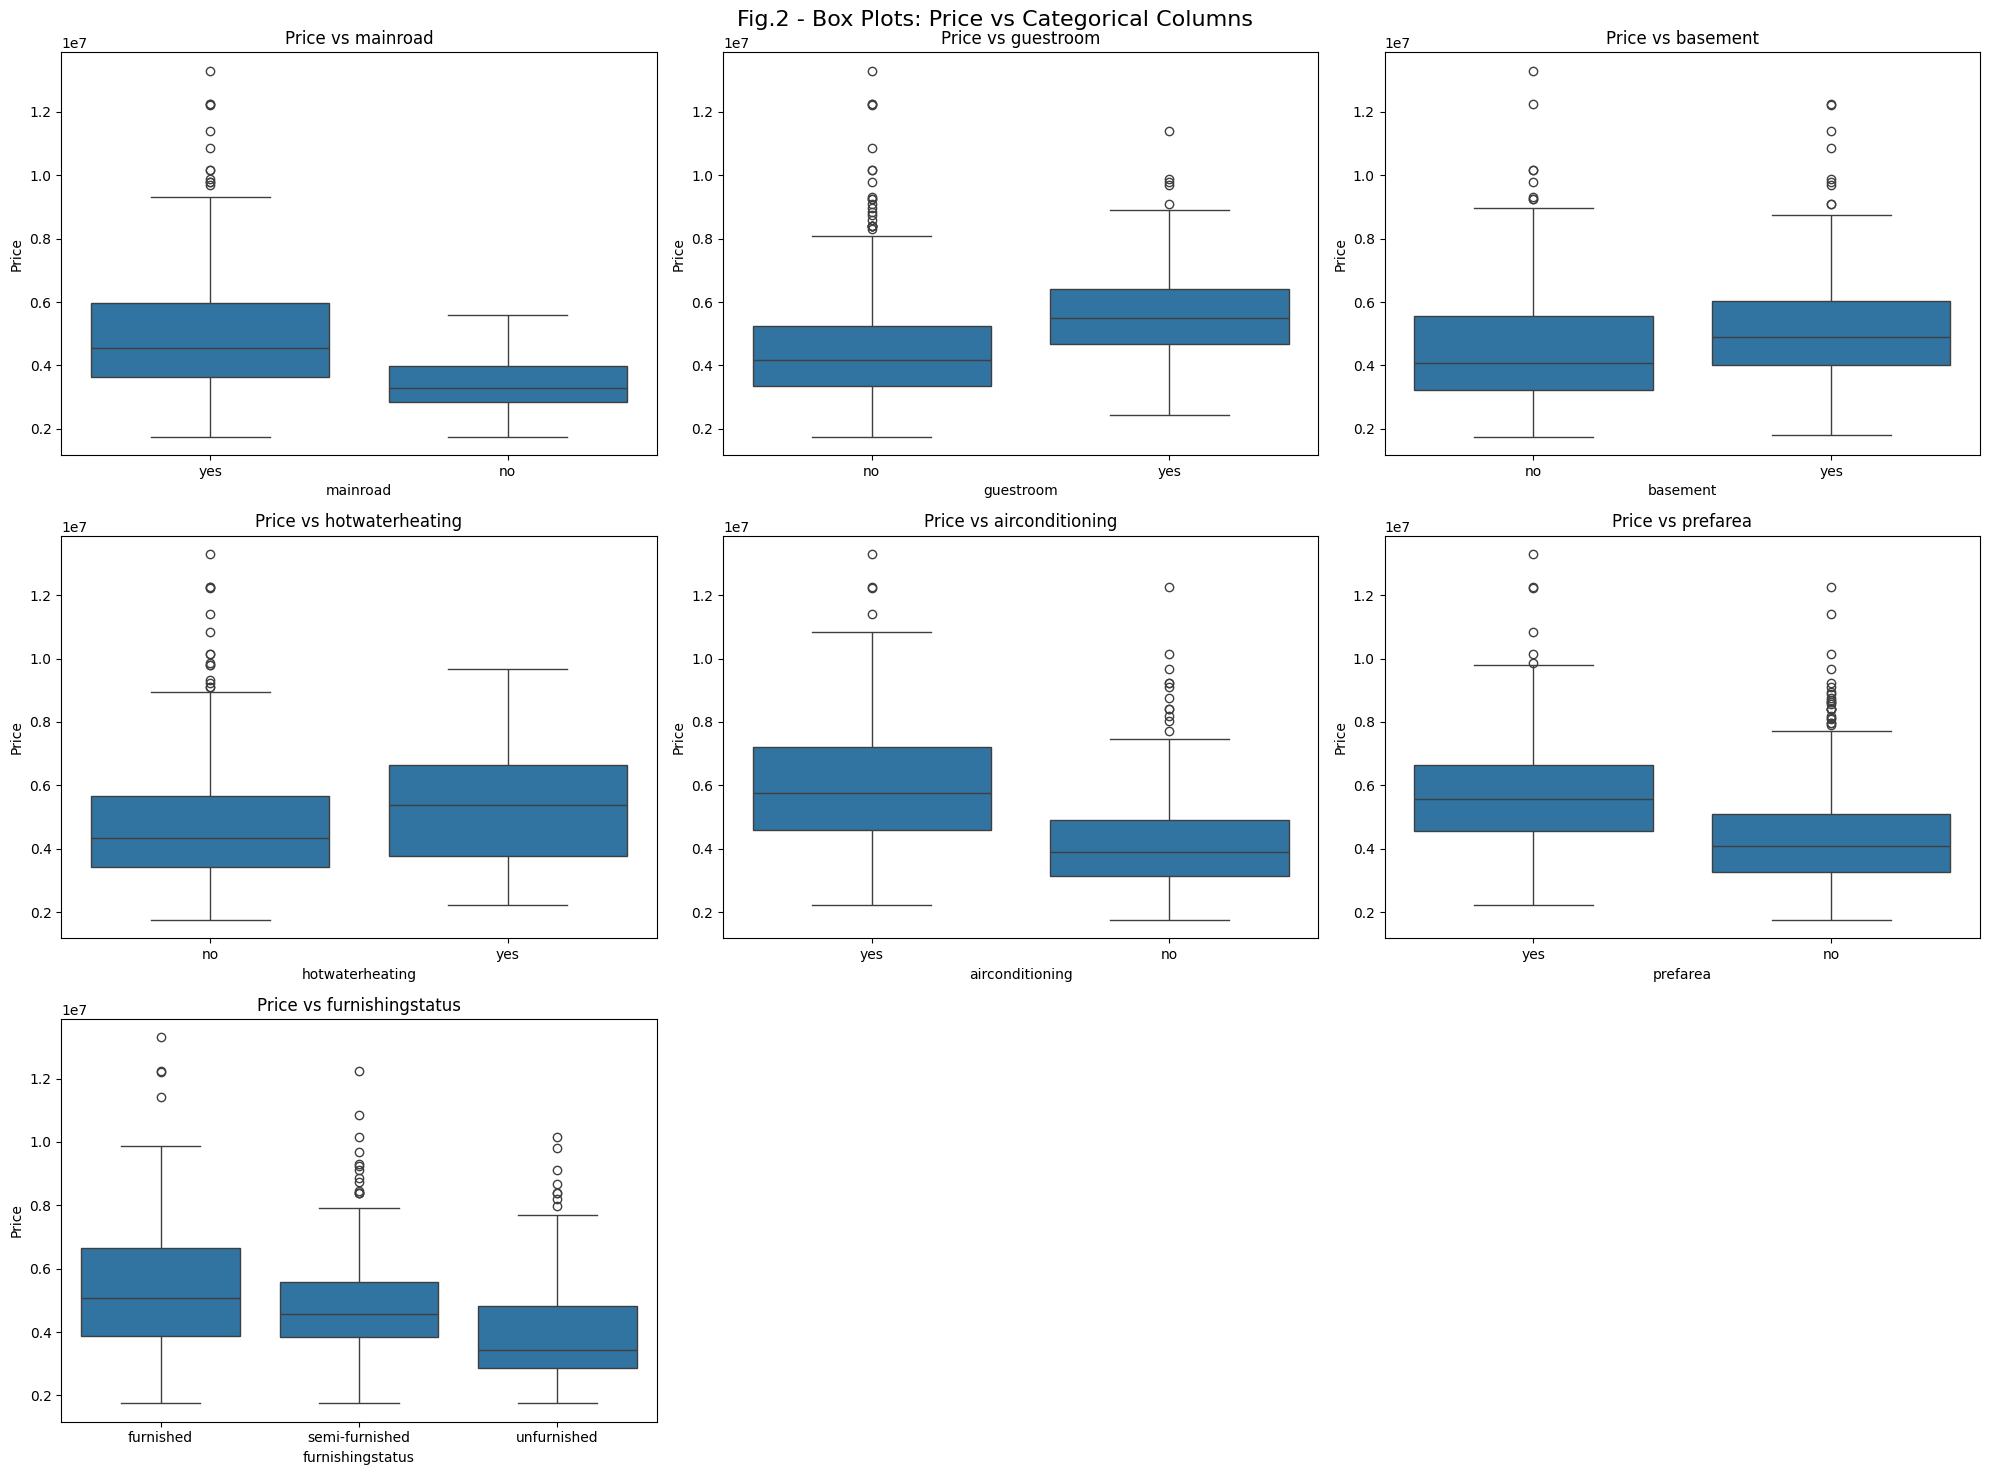

In [ ]:
# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 15))
fig.suptitle('Fig.2 - Box Plots: Price vs Categorical Columns', fontsize=16)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot box plots for each categorical column
for i, col in enumerate(categorical_columns):
    sns.boxplot(x=col, y='price', data=df, ax=axes[i])
    axes[i].set_title(f'Price vs {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Price')

# Remove empty subplots (if any)
for j in range(len(categorical_columns), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

- From **Figure 2**, we can observe the average price of houses across various conditions, along with the distribution of prices and any **extreme values (outliers)**. This visualization provides valuable insights into **how different factors influence housing prices**. Refer to Reference 1 to familiarize yourself with box plots.

- **General Trends:**  
  - The **average price** of houses is **higher** for properties that are **located on the main road, have a guestroom, a basement, hot water heating, air conditioning, are situated in a preferred area,** or are **furnished**, compared to properties without these features.  


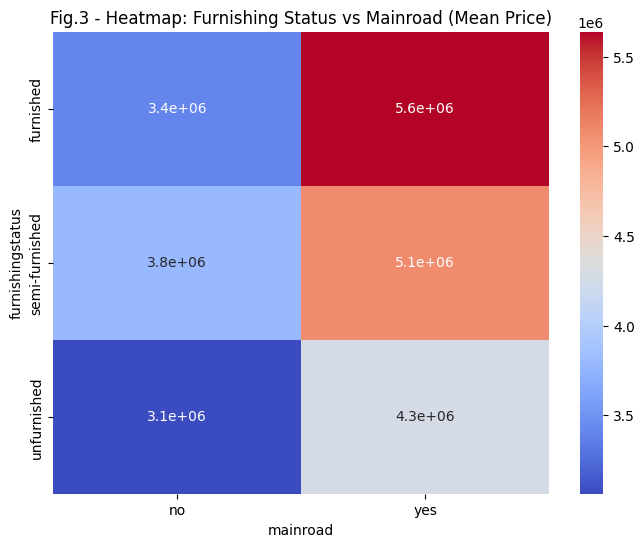

In [ ]:
# Group by categorical columns and analyze mean price
grouped_data = df.groupby(['furnishingstatus', 'mainroad'])['price'].mean().unstack()
plt.figure(figsize=(8, 6))
sns.heatmap(grouped_data, annot=True, cmap='coolwarm')
plt.title('Fig.3 - Heatmap: Furnishing Status vs Mainroad (Mean Price)')
plt.show()

- Fig.3 indicates that:
  - **Properties** located **on the main road** consistently have **higher mean prices** across **all furnishing statuses**.
  - **Furnished properties** tend to have **higher prices** compared to unfurnished ones, **regardless of location**.

## D. Data Pre-Processing

### D-1. Data Transformation

In [10]:
# Convert categorical data to numerical data
dummies = pd.get_dummies(df[categorical_columns], dtype=float)

# Create a copy of original data & drop uncessary columns
df_encoded = df.drop(columns=categorical_columns)

# Merge columns
df_encoded = pd.concat([df_encoded, dummies], axis=1)
print(df_encoded.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   price                            545 non-null    float64
 1   area                             545 non-null    float64
 2   bedrooms                         545 non-null    float64
 3   bathrooms                        545 non-null    float64
 4   stories                          545 non-null    float64
 5   parking                          545 non-null    float64
 6   mainroad_no                      545 non-null    float64
 7   mainroad_yes                     545 non-null    float64
 8   guestroom_no                     545 non-null    float64
 9   guestroom_yes                    545 non-null    float64
 10  basement_no                      545 non-null    float64
 11  basement_yes                     545 non-null    float64
 12  hotwaterheating_no    

In [11]:
# Drop duplicated column because of get_dummies
# List of columns to drop
columns_to_drop = []

# Identify redundant columns
for col in df_encoded.columns:
    if col.endswith('_no'):  # Drop columns ending with '_no'
        columns_to_drop.append(col)
    elif col.startswith('furnishingstatus_') and col != 'furnishingstatus_furnished' and col != 'furnishingstatus_semi-furnished':
        columns_to_drop.append(col)

# Drop the redundant columns
df_cleaned = df_encoded.drop(columns=columns_to_drop)

# Drop features that dont have linear relationship with dependent variable
df_cleaned = df_cleaned.drop(columns=['bedrooms','bathrooms','stories','parking'])
df_cleaned.head()

,price,area,mainroad_yes,guestroom_yes,basement_yes,hotwaterheating_yes,airconditioning_yes,prefarea_yes,furnishingstatus_furnished,furnishingstatus_semi-furnished
0,13300000.00,7420.00,1.00,0.00,0.00,0.00,1.00,1.00,1.00,0.00
1,12250000.00,8960.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00
2,12250000.00,9960.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00
3,12215000.00,7500.00,1.00,0.00,1.00,0.00,1.00,1.00,1.00,0.00
4,11410000.00,7420.00,1.00,1.00,1.00,0.00,1.00,0.00,1.00,0.00


### D-2. Data Splitting

In [69]:
# Define independent variables (X) and dependent variable (y)
X = df_cleaned.drop('price', axis=1)
y = df_cleaned['price']

# Scale numerical features
scaler = StandardScaler()
X['area'] = scaler.fit_transform(X[['area']])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## E. OLS Regression Model

In [63]:
# Fit the linear regression model
model = sm.OLS(y_train, sm.add_constant(X_train)).fit()

# Get residuals and fitted values
residuals = model.resid
fitted_values = model.fittedvalues

# Print model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.517
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     50.64
Date:                Wed, 26 Feb 2025   Prob (F-statistic):           6.43e-62
Time:                        04:44:43   Log-Likelihood:                -6729.1
No. Observations:                 436   AIC:                         1.348e+04
Df Residuals:                     426   BIC:                         1.352e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

**OLS Regression Summary**  

- **Model Fit:** The model explains **51.7%** of price variation (**R² = 0.517**).  

- **[F-statistic](https://journals.lww.com/jpcs/fulltext/2020/06020/f_test_of_overall_significance_in_regression.6.aspx#:~:text=HOW%20TO%20INTERPRET%20THE%20F,as%20a%20whole%20is%20useful.)**  
  - The **F-test** evaluates whether the regression model is useful as a whole.  
    - A significant p-value (**p < 0.05**) indicates the model performs better than one with no predictors.  
    - A non-significant p-value (**p > 0.05**) suggests the model is not useful.  
  - Even if the model is significant, individual predictor variables may still be insignificant:  
    - Key Predictors (**p < 0.05**): `Area, main road, hot water heating, air conditioning, preferred area, and furnishing status` **significantly impact** price.  
    - Insignificant Features (**p > 0.05**): `basement_yes` and `guestroom_yes` have **little effect** on price.  

- **Residual Diagnostics:**  
  - Durbin-Watson (1.846): Slightly below 2, indicating a mild positive autocorrelation—not strong enough to be a major concern.  
  - Omnibus & Jarque-Bera Tests (**p < 0.05**): Residuals **are not normally distributed**.  
  - Skewness (1.060) & Kurtosis (5.208): The data is **right-skewed with heavy tails**, suggesting potential **outliers** or **non-linearity**.  



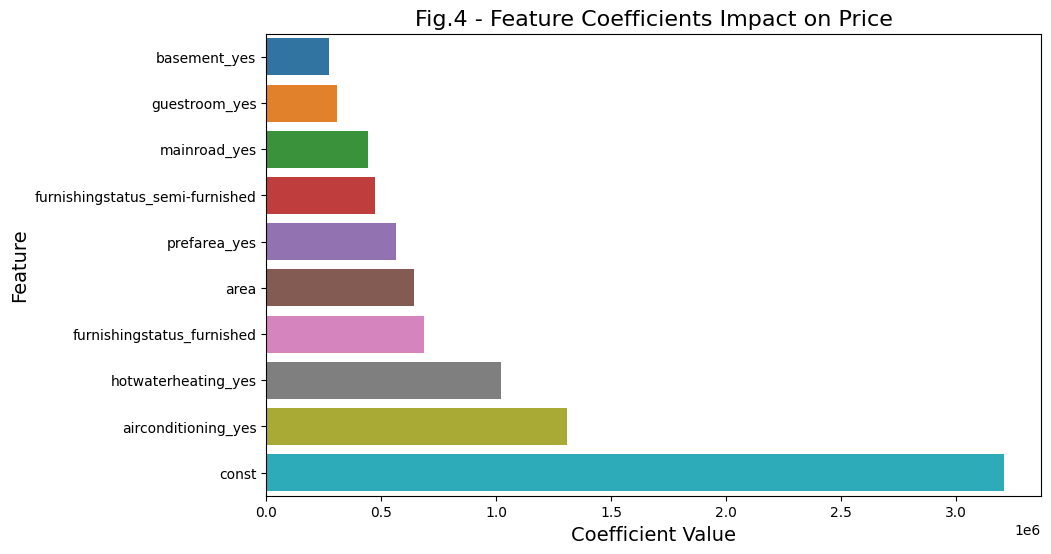

In [15]:
# Extract coefficients
coefficients = model.params
# Sort the data by coefficient values
coefficients = coefficients.sort_values(ascending=True)
coefficients= coefficients.reset_index()
coefficients.rename(columns={'index': 'Feature', 0: 'Coefficient'}, inplace=True)

# Set up the plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coefficients, hue="Feature", legend=False)

# Add labels and title
plt.title('Fig.4 - Feature Coefficients Impact on Price', fontsize=16)
plt.xlabel('Coefficient Value', fontsize=14)
plt.ylabel('Feature', fontsize=14)

# Display the plot
plt.show()

**Summary of Coefficients and Their Impact on Price:**  

1. **Intercept (const: $3.209M)**  
   - This is the base price of a house when all other features are 0.  

2. **Area (\$641,800 per unit increase)**  
   - A **larger area significantly increases the price**, with each unit increase in area adding **$641,800**.  

3. **Main Road (\$443,600 increase)**  
   - Houses near a **main road** tend to have **\$443,600 higher prices**, indicating better accessibility adds value.  

5. **Hot Water Heating (\$1.019M increase)**  
   - **Significantly impacts price**, increasing it by **$1.019 million**, likely due to luxury association.  

6. **Air Conditioning (\$1.308M increase)**  
   - A major factor in price increase, adding **$1.308 million**, showing strong buyer preference for comfort.  

7. **Preferred Area (\$564,700 increase)**  
   - Being in a **preferred area increases price by $564,700**, reflecting higher demand.  

8. **Furnishing Status:**  
   - **Furnished (+\$685,900)** → Highest increase among furnishing statuses.  
   - **Semi-Furnished (+\$471,200)** → Still adds value, but less than fully furnished homes.  



In [19]:
# Evaluate model on test data
y_pred = model.predict(sm.add_constant(X_test))

# Compute evaluation metrics
metrics = {
    "R² Score": r2_score(y_test, y_pred),
    "RMSE": root_mean_squared_error(y_test, y_pred),
    "MSE": mean_squared_error(y_test, y_pred),
}

# Convert metrics to DataFrame
df_metrics = pd.DataFrame([metrics],index=['OLS'])
np.round(df_metrics,2)

,R² Score,RMSE,MSE
OLS,0.49,1612248.34,2599344709863.16


## F. Detect violations of linear regression assumptions

The previous notebook briefly examines key assumptions of linear regression. If these assumptions are violated, the model may not generalize well. Therefore, this section focuses on evaluating whether the dataset is suitable for linear regression.

1. **Linearity**: The relationship between the features and the target variable is linear.
  - Plot scatterplots of each feature against the target variable.

2. **Independence**: The features are independent of each other (no multicollinearity).
  - Calculate the correlation matrix or Variance Inflation Factor (VIF)

3. **Homoscedasticity**: The residuals (errors) have constant variance across all levels of the predicted values.
  - Plot residuals vs. predicted values. If the spread of residuals increases or decreases with predicted values, homoscedasticity is violated.

4. **No Autocorrelation**: The residuals are not correlated with each other
  - Use the Durbin-Watson test

5. **Normality of Residuals**: The residuals are normally distributed.
  - Plot a histogram or Q-Q plot of the residuals.






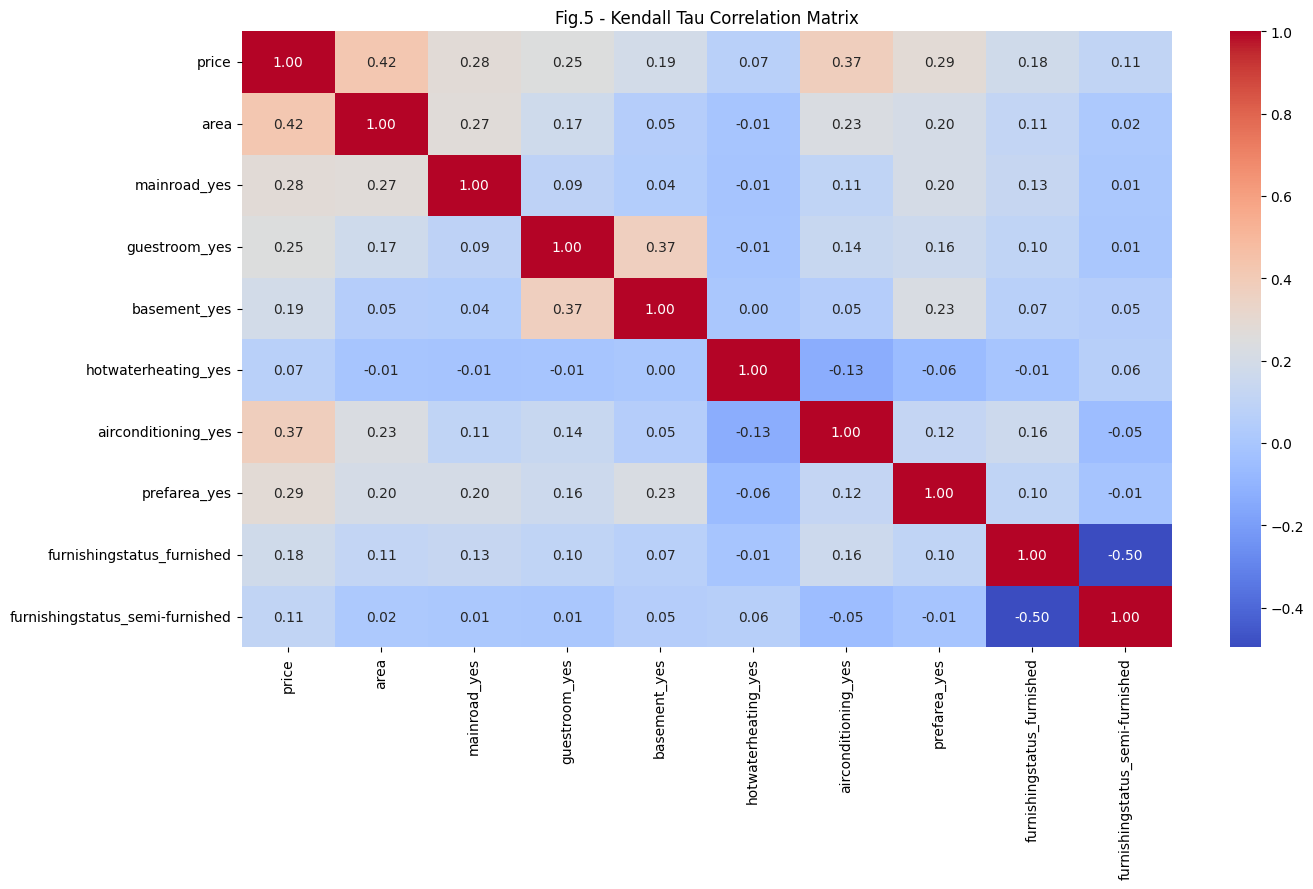

In [20]:
# 2. Independence: Calculate Kendall Tau correlation
corr_matrix = df_cleaned.corr(method='kendall')

# Plot the correlation matrix
plt.figure(figsize=(15, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Fig.5 - Kendall Tau Correlation Matrix')
plt.show()

We use the **Kendall Tau** correlation coefficient to explore the relationships between variables and understand their statistical connections.

- Kendall Tau is a **rank-based measure**, which makes it a great choice for **ordinal data** or datasets with **non-linear patterns**.

- Unlike Pearson correlation, which focuses on linear relationships, Kendall Tau is more r**esilient to outliers** and works well with **smaller** datasets or ordinal variables.

- As shown in Fig. 5, the dataset doesn’t show any extremely strong correlations between variables, which is a good sign for avoiding multicollinearity issues.

In [57]:
# 2. Independence: Variance Inflation Factor (VIF)
vif_data = pd.DataFrame()
vif_data['Variable'] = X_train.columns
vif_data['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
print("Variance Inflation Factor (VIF):")
print(vif_data)

Variance Inflation Factor (VIF):
                          Variable  VIF
0                             area 1.09
1                     mainroad_yes 3.35
2                    guestroom_yes 1.52
3                     basement_yes 1.91
4              hotwaterheating_yes 1.07
5              airconditioning_yes 1.57
6                     prefarea_yes 1.48
7       furnishingstatus_furnished 1.84
8  furnishingstatus_semi-furnished 2.12


**Meaning**:

- **VIF = 1** means no multicollinearity.  
- **VIF between 1 and 5** is safe—no major multicollinearity concerns.  
- **VIF above 5** signals strong multicollinearity, which can distort the model.  
- The **higher the VIF, the worse the multicollinearity.**

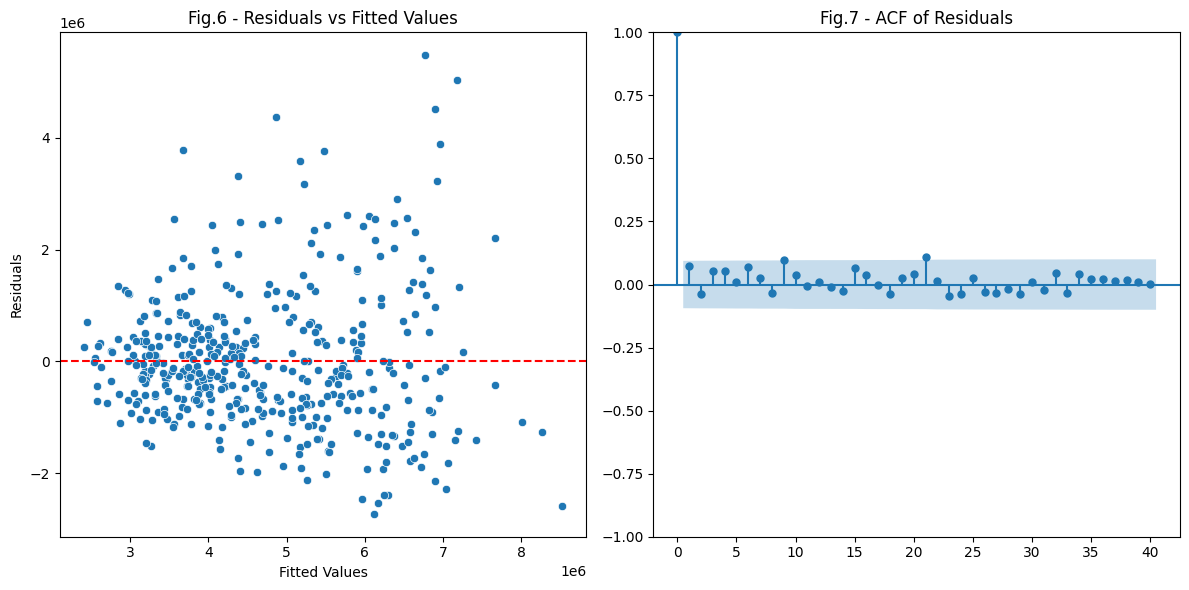

In [22]:
# 3. Homoscedasticity
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x=fitted_values, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Fig.6 - Residuals vs Fitted Values')

# 4. No Autocorrelation - Second subplot: ACF of residuals
plt.subplot(1, 2, 2)
plot_acf(residuals, lags=40, ax=plt.gca())  # Adjust lags as needed
plt.title('Fig.7 - ACF of Residuals')

plt.tight_layout()
plt.show()

From Figure 6, we observe that the residuals fan out, suggesting possible heteroscedasticity, which requires further investigation. To confirm this, we perform a Breusch-Pagan test below.

In [23]:
# Breusch-Pagan Test
name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test = het_breuschpagan(model.resid, model.model.exog)
pd.DataFrame(test, index=name, columns=[""])

,
Lagrange multiplier statistic,62.02
p-value,0.00
f-value,7.85
f p-value,0.00


- The test confirms the presence of **heteroskedasticity** since the **p-value is less than 0.05**.

- Additionally, Figure 7 shows that **residuals** are **significantly autocorrelated** at **lags 9 and 21**, indicating that past residuals may influence future residuals. This is evident because these two spikes fall outside the blue confidence area, reinforcing the Durbin-Watson result from the OLS Regression Summary.

  - The Durbin-Watson statistic ranges from 0 to 4:
    - A value close to **2** indicates **no autocorrelation**.
    - A value near **0** suggests **positive autocorrelation**.
    - A value near **4** suggests **negative autocorrelation**.

<Figure size 600x600 with 0 Axes>

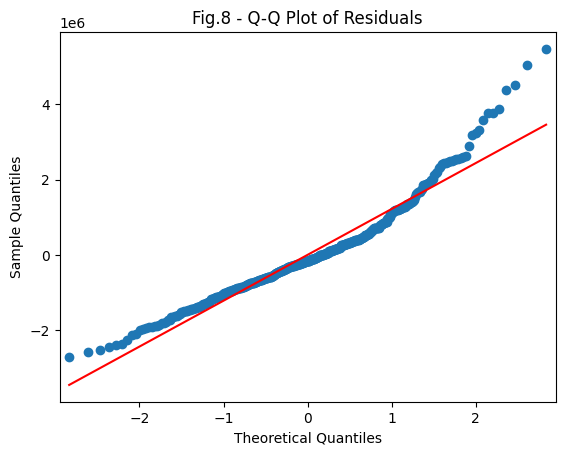

In [24]:
# 5. Q-Q Plot
plt.figure(figsize=(6, 6))
sm.qqplot(residuals, line='s')
plt.title('Fig.8 - Q-Q Plot of Residuals')
plt.show()

In [ ]:
# Shapiro-Wilk Test for Normality
shapiro_test = shapiro(residuals)
print("\nShapiro-Wilk Test for Normality:")
print(f"Test Statistic: {shapiro_test[0]}, p-value: {shapiro_test[1]}")


Shapiro-Wilk Test for Normality:
Test Statistic: 0.9424020216662227, p-value: 5.741630382948938e-12


- In **Shapiro-Wilk Test**, a very small p-value rejects the null hypothesis of normality. Combining the results from the QQ plot and the Shapiro-Wilk test, we conclude that the residuals do not follow a normal distribution.

**In Summary:**

- The dataset violates three key assumptions of Linear Regression:

  - **Linear Relationship** → The relationship between predictors and the target variable may not be linear, suggesting that nonlinear models could provide better predictions.

  - **Homoscedasticity** (Constant Variance of Residuals) → Presence of heteroskedasticity means that the model’s error variance is inconsistent across values, potentially leading to biased standard errors.

  - **Normality of Residuals** → Since residuals are not normally distributed, confidence intervals and hypothesis tests may be unreliable.

# **2. Weighted Least Squares**

- This section applies **Weighted Least Squares (WLS)** to the dataset to address potential issues of **heteroscedasticity**.

- **Why?**
  - **WLS** assigns more weight to observations with lower variance and less weight to observations with higher variance. This helps correct for heteroscedasticity, where the variance of residuals is not constant across data points.
  - **WLS** is more robust to outliers because it gives less weight to data points with large residuals, reducing their influence on the model.


In [70]:
# WLS regression result
# Add Absolute residuals and fitted values to dataset columns
abs_residuals = np.abs(model.resid)
fitted_values = model.fittedvalues

# Fit OLS model with absolute residuals and fitted values
model_2 = sm.OLS(abs_residuals, sm.add_constant(fitted_values)).fit()

# Compute weights
weights = model_2.fittedvalues
weights = weights**-2

# Fit the model
model_WLS = sm.WLS(y_train, sm.add_constant(X_train), weights).fit()
model_WLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.551
Model:                            WLS   Adj. R-squared:                  0.541
Method:                 Least Squares   F-statistic:                     58.02
Date:                Wed, 26 Feb 2025   Prob (F-statistic):           1.53e-68
Time:                        04:47:14   Log-Likelihood:                -6677.2
No. Observations:                 436   AIC:                         1.337e+04
Df Residuals:                     426   BIC:                         1.342e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                            3.244e+06   1.07e+05     30.195      0.000    3.03e+06    3.46e+06
area                             6.895e+05   6.87e+04     10.035      0.000    5.54e+05    8.25e+05
mainroad_yes                     3.547e+05   1.06e+05      3.342      0.001    1.46e+05    5.63e+05
guestroom_yes                    2.758e+05   1.82e+05      1.519      0.129    -8.1e+04    6.33e+05
basement_yes                     4.013e+05   1.15e+05      3.483      0.001    1.75e+05    6.28e+05
hotwaterheating_yes              8.279e+05   2.71e+05      3.058      0.002    2.96e+05    1.36e+06
airconditioning_yes              1.164e+06   1.48e+05      7.869      0.000    8.73e+05    1.45e+06
prefarea_yes                     5.193e+05   1.48e+05      3.520      0.000    2.29e+05    8.09e+05
furnishingstatus_furnished       6.581e+05   1.39e+05      4.736      0.000    3.85e+05    9.31e+05
furnishingstatus_semi-furnished  6.281e+05   1.01e+05      6.217      0.000     4.3e+05    8.27e+05
==============================================================================
Omnibus:                       62.579   Durbin-Watson:                   1.842
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               94.712
Skew:                           0.924   Prob(JB):                     2.71e-21
Kurtosis:                       4.342   Cond. No.                         8.63
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.35e-11. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

**Model Diagnostics:**

- **Omnibus Test:** The p-value of 0.000 suggests that the residuals are **not normally distributed**.
  
- **Durbin-Watson Statistic (1.994):** Close to 2, indicating **no significant autocorrelation** in the residuals.

- **Jarque-Bera Test:** The p-value is very small (1.97e-10), which, along with the Omnibus test, confirms **non-normality of residuals**.

- **Skew (0.664):** Indicates a **slight right skew** in the residuals.

- **Kurtosis (3.835):** Close to 3, which suggests **moderate tail heaviness**, indicating that the residuals have a distribution close to normal but with slightly heavier tails.

Regarding the **WLS and multicollinearity** part:

- **WLS and Multicollinearity:** When weights are applied in **WLS**, they can alter the relationships between the independent variables, which might introduce or amplify **multicollinearity**. This occurs because WLS assigns different weights to observations, and this can affect the correlation between predictors.

# **3. Robust Linear Regression model**

Next, we apply Robust Regression using **HuberT** and **Tukey’s Biweight** to improve the model's performance by handling outliers and heteroscedasticity, and compare the results to the ones of the OLS and WLS models.

Key Reasons for Using Robust Regression:
   - **HuberT** and **Tukey’s Biweight** are M-estimators that reduce the effect of large residuals.
   - They **assign less weight** to outliers, making the **model** more **robust**.

Difference Between HuberT and Tukey Biweight:

| Method | How It Works |
|---------|-------------|
| **HuberT** | Combines OLS (for small residuals) with L1 loss (for large residuals). <br> This reduces the impact of outliers but still allows them to contribute. |
| **Tukey’s Biweight** | Fully ignores extreme outliers by assigning **zero weight** to large residuals. <br> This eliminates the influence of extreme residuals entirely. |



In [76]:
# Method 1: Robust-HuberT Regression model
rr_huber = sm.RLM(y_train, sm.add_constant(X_train), M=sm.robust.norms.HuberT())
rr_huber_results = rr_huber.fit()

# Print the summary
print(rr_huber_results.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                  price   No. Observations:                  436
Model:                            RLM   Df Residuals:                      426
Method:                          IRLS   Df Model:                            9
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 26 Feb 2025                                         
Time:                        04:48:42                                         
No. Iterations:                     2                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [77]:
# Method 2: Bisquare Method model
rr_bisquare = sm.RLM(y_train, sm.add_constant(X_train),M=sm.robust.norms.TukeyBiweight())
rr_bisquare_results = rr_bisquare.fit()
print(rr_bisquare_results.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                  price   No. Observations:                  436
Model:                            RLM   Df Residuals:                      426
Method:                          IRLS   Df Model:                            9
Norm:                   TukeyBiweight                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 26 Feb 2025                                         
Time:                        04:48:47                                         
No. Iterations:                     2                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [79]:
# Make predictions on the test set
# WLS
y_pred_wls = model_WLS.predict(sm.add_constant(X_test))
df_metrics.loc['WLS'] = [r2_score(y_test, y_pred_wls), np.sqrt(mean_squared_error(y_test, y_pred_wls)),mean_squared_error(y_test, y_pred_wls)]
# Huber
y_pred_huber = rr_huber_results.predict(sm.add_constant(X_test))
df_metrics.loc['HuberT'] = [r2_score(y_test, y_pred_huber), np.sqrt(mean_squared_error(y_test, y_pred_huber)),mean_squared_error(y_test, y_pred_huber)]
# Bisquare
y_pred_tukey = rr_bisquare_results.predict(sm.add_constant(X_test))
df_metrics.loc['TukeyBiweight'] = [r2_score(y_test, y_pred_tukey), np.sqrt(mean_squared_error(y_test, y_pred_tukey)),mean_squared_error(y_test, y_pred_tukey)]
df_metrics

,R² Score,RMSE,MSE
OLS,0.49,1612248.34,2599344709863.16
HuberT,0.46,1650722.79,2724885745049.78
TukeyBiweight,0.45,1664197.37,2769552888915.90
WLS,0.48,1616514.41,2613118822842.56


- **Conclusion:** While OLS provides the best fit in terms of the R² score, all models have substantial prediction errors, as indicated by the high RMSE and MSE values. The WLS, HuberT, and Tukey’s Biweight models, while more robust to outliers, do not significantly outperform OLS in this case.

# **3. Prediction**

In [80]:
# Predictions
prediction_df = pd.DataFrame()
prediction_df['Observation'] = y_test
prediction_df['OLS'] = y_pred
prediction_df['Huber'] = y_pred_huber
prediction_df['TukeyBiweight'] = y_pred_tukey
prediction_df.head()

,Observation,OLS,Huber,TukeyBiweight
316,4060000.00,3702885.70,3649271.08,3608379.37
77,6650000.00,6611173.51,6428422.93,6357325.48
360,3710000.00,3795372.74,3759859.05,3766256.82
90,6440000.00,5387716.57,5266622.45,5251605.52
493,2800000.00,3986437.03,3916431.85,3890052.33


In [81]:
# Define values
values = [6000, 0.00, 0.00, 1.00, 0.00, 0.00, 1.00, 0.00, 0.00]

# Create DataFrame
new_data = pd.DataFrame([values], columns=X_test.columns)
new_data['area'] = scaler.fit_transform(new_data[['area']])

# Predict price
new_data = sm.add_constant(new_data, has_constant='add')
new_data['Prediction'] = model.predict(new_data)
new_data

,const,area,mainroad_yes,guestroom_yes,basement_yes,hotwaterheating_yes,airconditioning_yes,prefarea_yes,furnishingstatus_furnished,furnishingstatus_semi-furnished,Prediction
0,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,4045683.59


In conclusion, **Linear regression** is **not suitable** for explaining **this dataset** due to its reliance on a linear relationship between the dependent and independent variables. The next notebook explores alternative methods that do not require such a linear assumption.

**Sources:**

- [Outlier detection with Boxplots](https://medium.com/@agarwal.vishal819/outlier-detection-with-boxplots-1b6757fafa21)

- [Assumptions of Linear Regression](https://www.geeksforgeeks.org/assumptions-of-linear-regression/#detecting-violations-of-assumptions)

- [Understanding Autocorrelation and Partial Autocorrelation Functions (ACF and PACF)](https://medium.com/@kis.andras.nandor/understanding-autocorrelation-and-partial-autocorrelation-functions-acf-and-pacf-2998e7e1bcb5)
